In [1]:
import torch
import numpy as np
from torchvision import datasets, transforms
from pathlib import Path
import spyrit.misc.walsh_hadamard as wh
import sys

from spyrit.misc.statistics import stat_walsh_stl10
# from spyrit.misc.statistics import *
from spyrit.misc.disp import *

from spyrit.learning.model_Had_DCAN import *

In [2]:
img_size = 64 # image size
M = 512
# M = 1024 # number of measurements
N0 = 10    # Image intensity (in photons)
bs = 5 # Batch size

#- Model and data paths
data_root = Path('../../data/')
stats_root = Path('../../data/stats_walsh')

In [3]:
#%% A batch of STL-10 test images
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(7)

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

testset = \
    datasets.STL10(root=data_root, split='test',download=False, transform=transform)
testloader =  torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

In [4]:
inputs, _ = next(iter(testloader))
b,c,h,w = inputs.shape

In [5]:
# stat_walsh_stl10()
Cov = np.load(stats_root / Path("Cov_{}x{}.npy".format(img_size, img_size)))
Mean = np.load(stats_root / Path("Average_{}x{}.npy".format(img_size, img_size)))
H =  wh.walsh2_matrix(img_size)
# H =  wh.walsh2_matrix(img_size)/img_size


Ord = Cov2Var(Cov)
Perm = Permutation_Matrix(Ord)
Hperm = Perm@H; #for new
Pmat = Hperm[:M,:];


Cov_had = Cov/img_size**2 # previous
Mean_had = Mean/img_size # previous

Cov_perm = Perm@Cov@Perm.T;

In [6]:
print(np.amax(Cov_perm))

838554.125


In [7]:
x = inputs.view(b*c,w*h)
x_0 = torch.zeros_like(x)

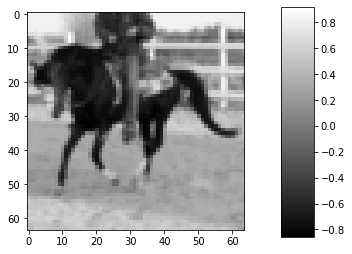

In [8]:
img = x[0,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

In [9]:
from spyrit.restructured.Updated_Had_Dcan import * 

In [10]:
FO_split = Split_Forward_operator(Pmat)
A_b = Bruit_Poisson_approx_Gauss(N0, FO_split)
SPP = Split_diag_poisson_preprocess(N0, M, w*h)

In [11]:
m = A_b(x)
y = SPP(m,FO_split)
var = SPP.sigma(m)

In [14]:
print(m[0])

tensor([22450.6152,     0.0000,  9653.0137,  ..., 11233.0010, 11060.4639,
        11323.3066])


In [18]:
print(y[0])

tensor([ 3.9412e+02, -5.8727e+02,  5.9782e+02,  1.5877e+02,  1.5808e+02,
         4.8082e+02, -3.5462e+02,  4.0927e+02,  1.2030e+02, -2.8969e+02,
         8.9801e+01,  4.1385e+01,  1.8484e+02,  2.9149e+02,  3.2205e+02,
        -8.8718e+01,  1.4570e+01,  1.5141e+02,  2.5714e+01, -7.0926e+00,
        -4.1056e+01,  7.3077e+01, -7.2906e+01,  1.4312e+02,  2.4945e+02,
         9.6610e+01,  7.2946e+01,  1.6788e+02,  1.7404e+02,  9.2536e+01,
         2.1503e+02,  1.3770e+02,  1.1559e+02, -1.7877e+02, -6.2467e+01,
        -8.5922e+01,  1.1402e+02, -1.3945e+02,  7.0488e+01,  1.1935e+02,
         5.8671e+01, -5.1033e+00, -8.0175e+01,  1.1278e+02,  1.3693e+02,
        -1.0154e+00, -7.6751e+01, -5.5631e+01,  1.2723e+02, -2.3969e+02,
        -5.1591e+01,  6.7193e+01, -1.8257e+02,  7.3749e+01,  8.5177e+01,
         1.1935e+02, -5.9201e+01, -5.9744e+01, -7.0538e+01,  8.3396e+00,
         2.5555e+01,  9.5669e+01,  7.9907e+01, -1.0234e+02,  3.3125e+01,
         7.2620e+01, -1.4626e+01,  8.0929e+01,  1.6

In [19]:
print(var[0])

tensor([898.0246, 889.6942, 896.8279, 898.3438, 893.0863, 889.9475, 877.3438,
        886.9525, 891.7281, 880.7531, 889.7994, 892.3986, 893.6746, 896.0708,
        899.9338, 894.6955, 890.2246, 879.6746, 901.8167, 899.2578, 886.1719,
        891.1096, 892.0179, 902.3947, 893.3380, 889.7672, 887.4598, 885.0538,
        886.4381, 885.4994, 892.8274, 895.0836, 881.8749, 881.1412, 888.1230,
        902.3600, 902.2619, 888.2747, 890.8542, 881.4144, 901.3547, 887.7967,
        895.1291, 898.6719, 902.3727, 904.9914, 896.5941, 900.5627, 890.8792,
        892.2961, 899.7310, 897.6808, 887.5137, 894.0947, 894.9888, 892.4352,
        896.6667, 887.7555, 894.0769, 894.9327, 890.2572, 891.5055, 903.7559,
        889.4705, 902.5571, 890.2841, 895.9280, 896.6041, 883.5396, 896.5115,
        886.3336, 900.0208, 894.7530, 898.8445, 891.0103, 893.3624, 900.2473,
        891.4716, 897.4031, 882.1320, 890.7109, 889.1108, 877.6738, 890.9902,
        893.8333, 896.8987, 898.4897, 890.7422, 898.0837, 905.65

# Generalized_Orthogonal_Tikhonov (Validated)
## Instantiation

In [12]:
FO_split_had = Split_Forward_operator_ft_had(Pmat, Perm)
P = Generalized_Orthogonal_Tikhonov(sigma_prior = Cov_perm, M = M, N = h*w)
Pinv = Pinv_orthogonal()

## Test methode forward

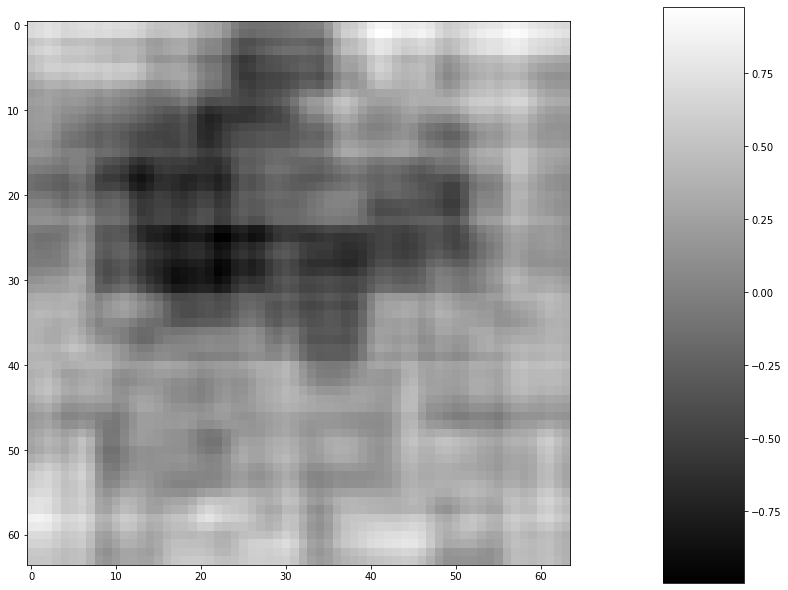

In [13]:
x_est = P(y, x_0, var, FO_split_had)
plt.rcParams['figure.figsize'] = [15, 10]
img = x_est[0,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

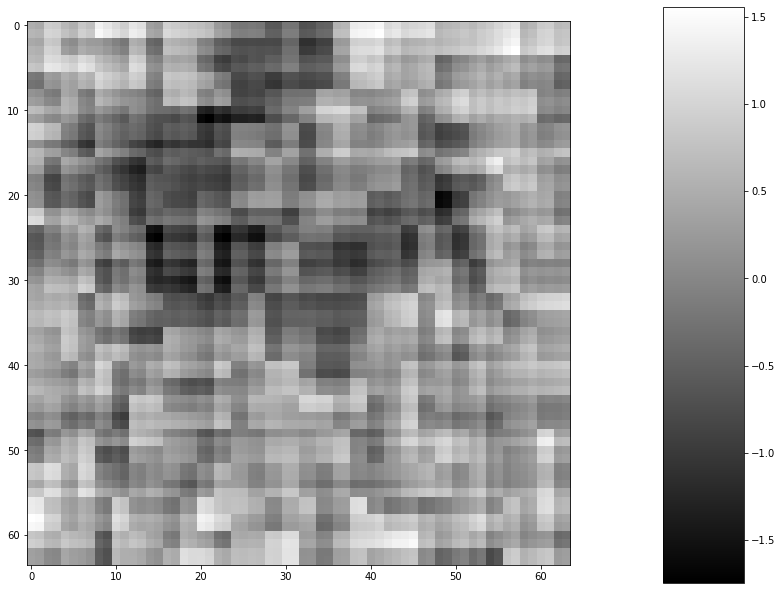

In [14]:
x_est = Pinv(y, FO_split_had)
plt.rcParams['figure.figsize'] = [15, 10]
img = x_est[0,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

In [15]:
N0_list = [2, 5, 10, 50, 2500];
outlist = [];
out_pinv = [];
prevlist = [];
for N0 in N0_list:    
    FO_split_had = Split_Forward_operator_ft_had(Pmat, Perm)
    Acq = Bruit_Poisson_approx_Gauss(N0, FO_split_had)
    PreP = Split_diag_poisson_preprocess(N0, M, w*h)
    DC_layer = Generalized_Orthogonal_Tikhonov(sigma_prior = Cov_perm, M = M, N = h*w)
    Denoi = ConvNet()
    model_new = DC_Net(Acq, PreP, DC_layer, Denoi)
    model_new.eval()
    
    
    model = DenoiCompNet(img_size, M, Mean_had, Cov_had, variant=0, N0=N0, H=H/img_size)
    model.eval();
    
    m = Acq(x);
    m_mem = torch.clone(m)
    y = PreP(m,FO_split);
    var = PreP.sigma(m);

    
    x_Pinv = Pinv(y, FO_split);
    out_pinv.append(torch2numpy(x_Pinv.view(1,bs, 1, h, w)))
    
    x_est = model_new.reconstruct_mmse(m_mem.view(bs, 1, 2*M))
    outlist.append(torch2numpy(x_est.view(1,bs, 1, h, w)))
    
    recon_free = model.forward_reconstruct_mmse(m_mem, b, c, h, w)

    prevlist.append(torch2numpy(recon_free.view(1,bs, 1, h, w)))
    

Measurement to image domain: statistical completion (no mean)
Varying N0 = 2 +/- 0
Denoised Measurements
Measurement to image domain: statistical completion (no mean)
Varying N0 = 5 +/- 0
Denoised Measurements
Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Measurement to image domain: statistical completion (no mean)
Varying N0 = 50 +/- 0
Denoised Measurements
Measurement to image domain: statistical completion (no mean)
Varying N0 = 2500 +/- 0
Denoised Measurements


In [16]:
# N0_list = [2, 5, 10, 50, 2500];
# outlist = [];
# out_pinv = [];
# prevlist = [];
# for N0 in N0_list:
#     FO_split = Split_Forward_operator(Pmat)
#     A_b = Bruit_Poisson_approx_Gauss(N0, FO_split)
#     SPP = Split_diag_poisson_preprocess(N0, M, w*h)
    
#     model = DenoiCompNet(img_size, M, Mean_had, Cov_had, variant=0, N0=N0, H=H/img_size)
#     model.eval();
    
#     m = A_b(x);
#     m_mem = torch.clone(m)
#     y = SPP(m,FO_split);
#     var = SPP.sigma(m);

    
#     x_Pinv = Pinv(y, FO_split);
#     out_pinv.append(torch2numpy(x_Pinv.view(1,bs, 1, h, w)))
    
#     x_est = P(y, x_0, var, FO_split_had);
#     outlist.append(torch2numpy(x_est.view(1,bs, 1, h, w)))
    
#     recon_free = model.forward_reconstruct_mmse(m_mem, b, c, h, w)

#     prevlist.append(torch2numpy(recon_free.view(1,bs, 1, h, w)))

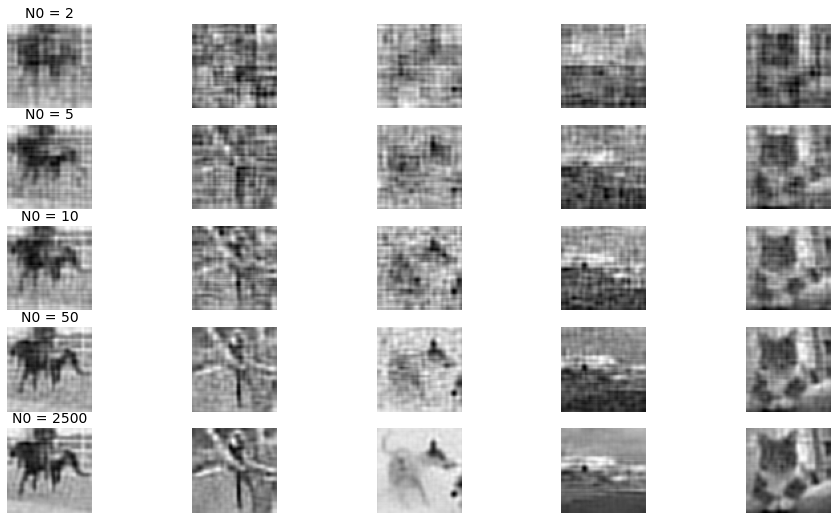

In [17]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 20]

nb_disp_frames = len(N0_list)
outputs_0 = outlist;
title_lists_0 = []
title_lists_0.append(["N0 = 2"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 5"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 10"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 50"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 2500"]+["" for i in range(bs-1)])
compare_video_frames(outputs_0, nb_disp_frames, title_lists_0, savefig = '');

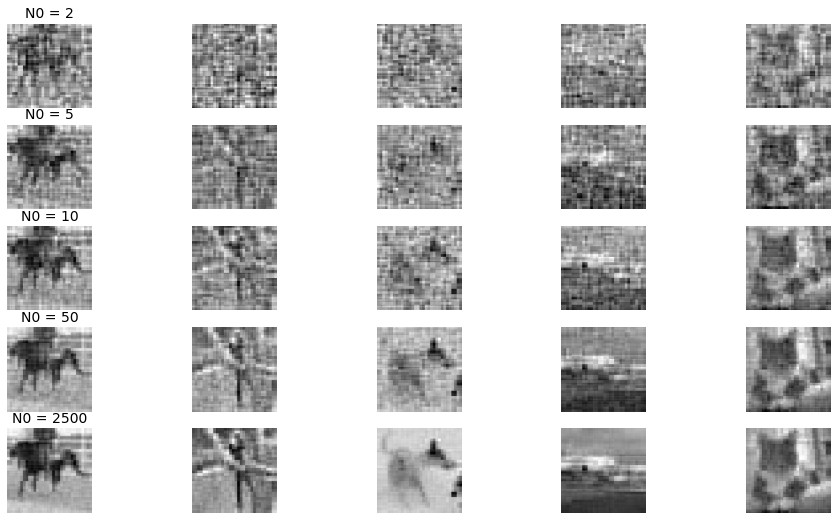

In [18]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 20]

nb_disp_frames = len(N0_list)
outputs_0 = out_pinv;
title_lists_0 = []
title_lists_0.append(["N0 = 2"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 5"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 10"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 50"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 2500"]+["" for i in range(bs-1)])
compare_video_frames(outputs_0, nb_disp_frames, title_lists_0,savefig = '');

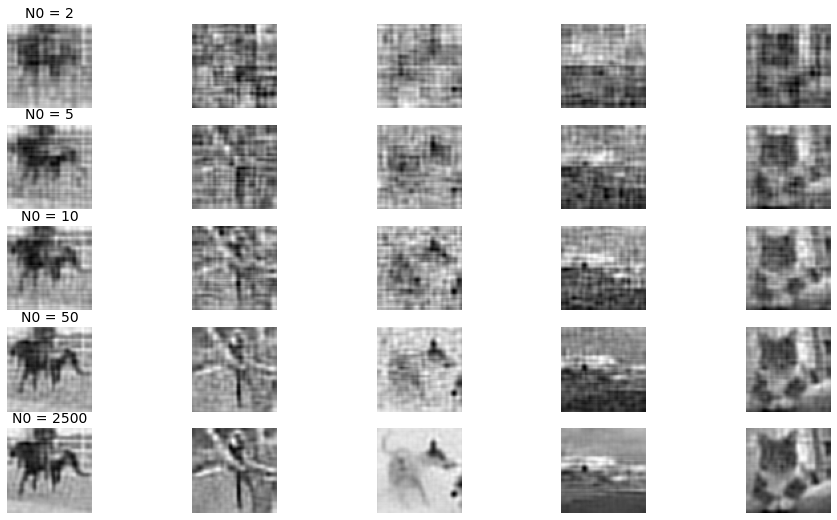

In [19]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 20]

nb_disp_frames = len(N0_list)
outputs_0 = prevlist;
title_lists_0 = []
title_lists_0.append(["N0 = 2"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 5"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 10"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 50"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 2500"]+["" for i in range(bs-1)])
compare_video_frames(outputs_0, nb_disp_frames, title_lists_0,savefig = '');

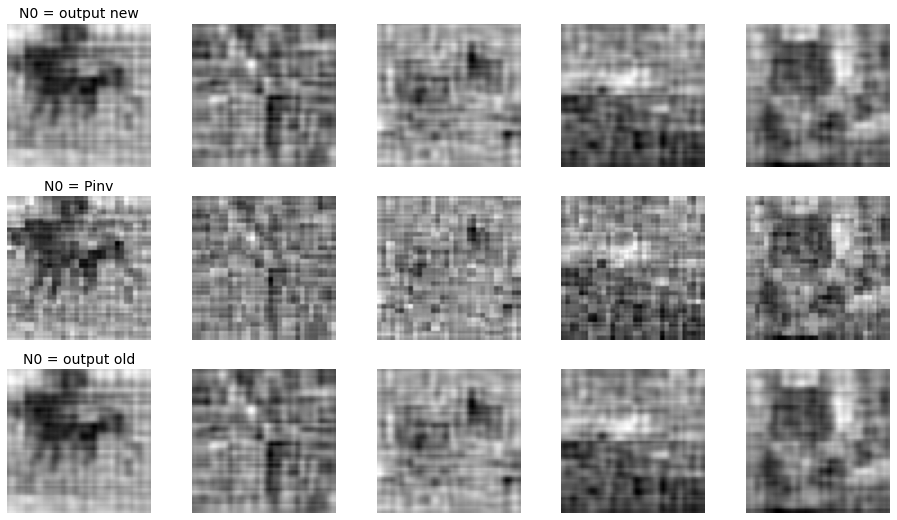

In [20]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 20]

nb_disp_frames = len(N0_list)
outputs_0 = [outlist[1], out_pinv[1], prevlist[1]];
title_lists_0 = []
title_lists_0.append(["N0 = output new"]+["" for i in range(bs-1)]) 
title_lists_0.append(["N0 = Pinv"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = output old"]+["" for i in range(bs-1)])
compare_video_frames(outputs_0, nb_disp_frames, title_lists_0,savefig = '');

In [21]:
np.linalg.norm(outlist[0][0,0,0,:,:]-torch2numpy(inputs[0,0,:,:]))

17.142626

In [22]:
np.linalg.norm(prevlist[0][0,0,0,:,:]-torch2numpy(inputs[0,0,:,:]))

17.142626

In [23]:
outlist[0].shape

(1, 5, 1, 64, 64)

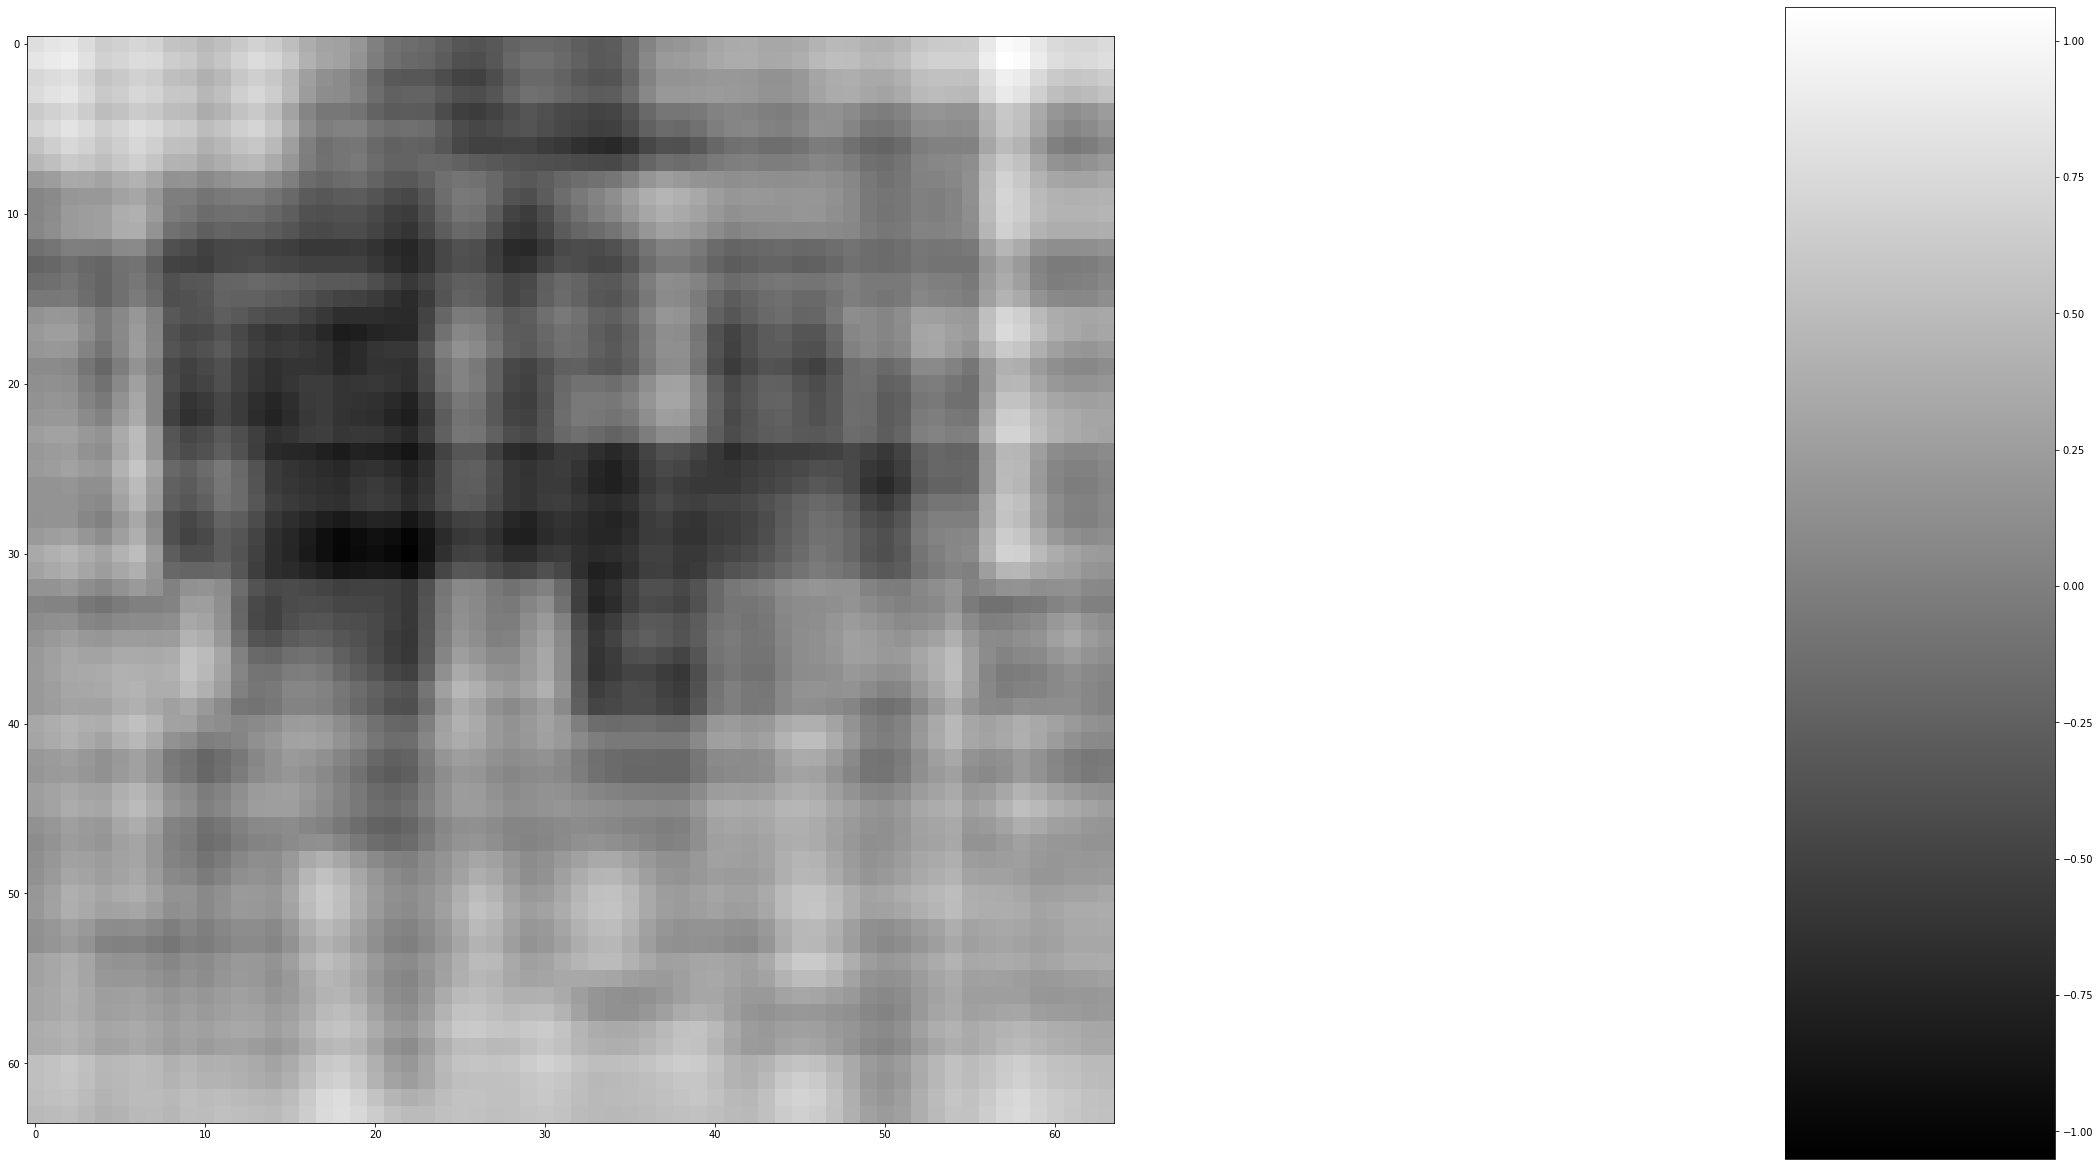

In [24]:
imagesc(prevlist[0][0,0,0,:,:])

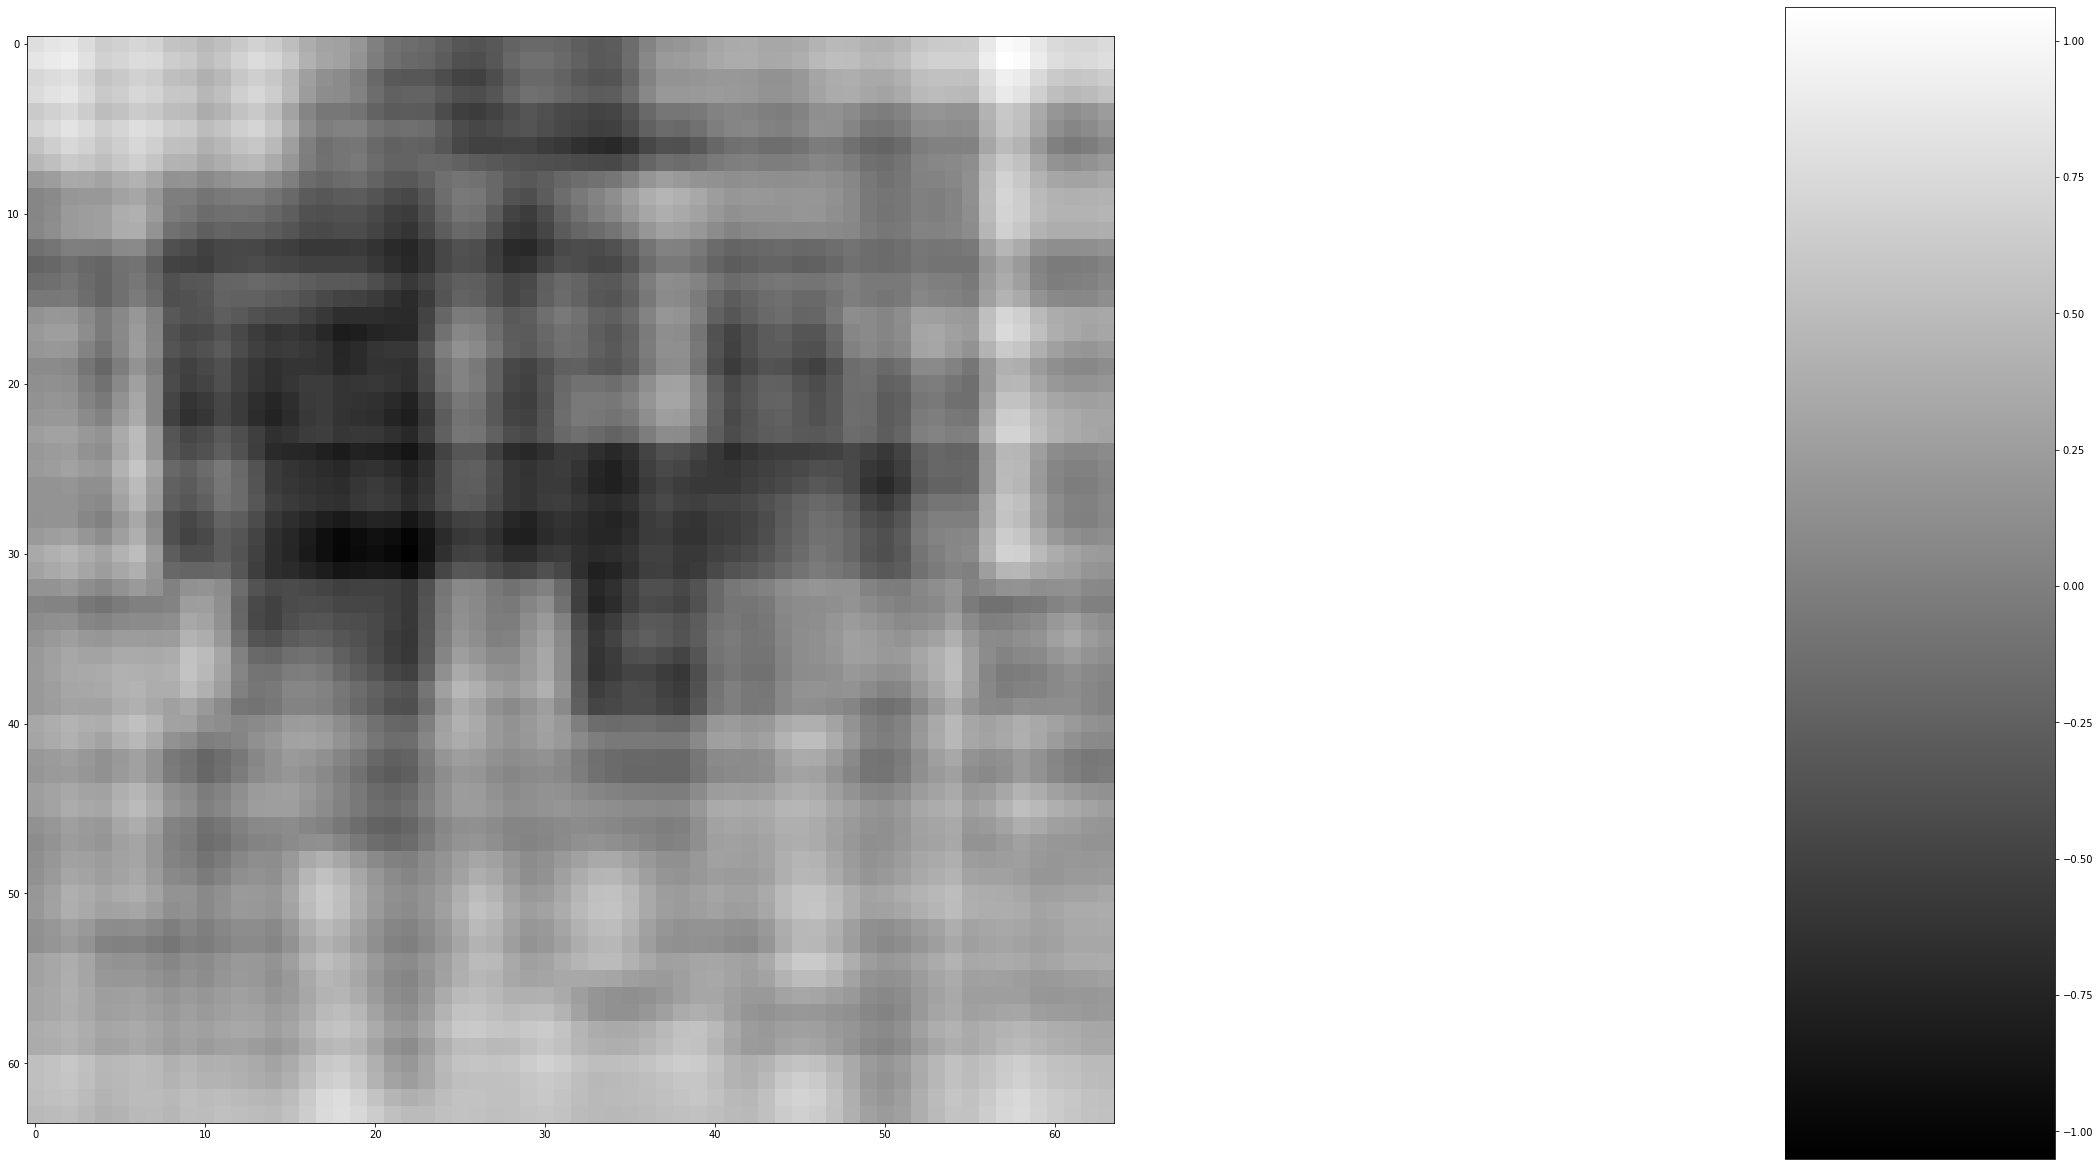

In [25]:
imagesc(outlist[0][0,0,0,:,:])